# Basic example


This example contains the most commonly used objects, attributes, functions and commands for a basic SHOP model, in addition to examples of how to review and plot input data and results. 

It is not dependent on any other data sources such as ASCII files or spreadsheets, as all input data remain intact in the notebook (or Python code) itself, and is fully dependent on the API and pyshop for interacting with SHOP.

The example watercourse consist of a simple SHOP model with two reservoirs and two plants which is optimized over the span of three days. 

We will show how to import all necessary packages, settings and data, create a SHOP instance and add all needed objects and populate them with data, before we run SHOP with a selection of commands and review the results in the end.

While the model in this example is quite simple, it can serve as a good reference when designing your own models. It illustrates an intuitive way of designing models in PyShop by incrementally initializing new objects like reservoirs, plants, generators and markets, setting their key attributes before connecting them together into the a desired topology. The model is then optimized, before the results are retrieved and presented through plots.

## Imports and settings

The first thing we do is to import the needed packages. You can import whichever packages you like, however we use the following ones for this example:

* Pandas for structuring our data into dataframes
* Cufflinks and Plotly for dynamic graph plotting
* Pyshop in order to create a SHOP session

In [1]:
import pandas as pd
import cufflinks as cf
from cufflinks import tools
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from pyshop import ShopSession

Additionally, we set Cufflinks and Plotly to an offline state, only usable in this notebook/environment, without any cloud connectivity:

In [2]:
cf.go_offline()

## Instancing SHOP

In order to have SHOP receive our inputs, run the model we create and give us results, we need to create an active, running SHOP session.

You may create multiple SHOP sessions simultaneously if needed.

In [3]:
# Creating a new SHOP session to the instance 'shop'
shop = ShopSession()

We can also check the current versions of SHOP and its solvers.

In [4]:
# Writing out the current version of SHOP and its solvers
shop.shop_api.GetVersionString()

'14.1.0.0 Cplex 20.1.0 Gurobi 7.5 OSI/CBC 2.9 2021-11-03'

## Setting time resolutions for the model

We set the time resolution for the model ourselves, as we generate all input as we go. The start and end time are important, in addition to the resolution of the time steps.

In [5]:
# Setting the start time of the model
starttime = pd.Timestamp('2018-01-23 00:00:00')

# Setting the end time of the model
endtime = pd.Timestamp('2018-01-26')

# Setting the start and end time to the shop instance, and defining the time unit
shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour", timeresolution=pd.Series(index=[starttime],data=[1]))

## Adding topology parameters

In this example we define the entire topology and generate all its parameters via Python and the API. Below are simple examples on how to define the most common topology objects needed in order to run SHOP.

### Reservoirs

First, we start of by creating our reservoir objects. It is possible to just execute the function, or we can instance them. The latter is preferred, as the syntax for adding attributes to objects become shorter, in addition to it being handy.

In [6]:
# Add reservoir objects to the model and instancing them
rsv1 = shop.model.reservoir.add_object('Reservoir1')
rsv2 = shop.model.reservoir.add_object('Reservoir2')
# Alternatively, only the right hand side can be executed, however it is often nice to refer to instances later on

We can then verify that all reservoir objects are correctly added to the model instance:

In [7]:
shop.model.reservoir.get_object_names()

['Reservoir1', 'Reservoir2']

Next, it is time to set the different parameters to the newly created objects, either via the instance, or directly through the function. Below are examples of both.

In [8]:
# Setting the maximum volume in Mm3 via the instance 
rsv1.max_vol.set(39)
rsv2.max_vol.set(97.5)

# Setting the LRL (Lowest Regulated Level) of the reservoir in masl via the instance 
rsv1.lrl.set(860)
rsv2.lrl.set(650)

# Setting the HRL (Highest Regulated Level) of the reservoir in masl by command
shop.model.reservoir.Reservoir1.hrl.set(905)
shop.model.reservoir.Reservoir2.hrl.set(679)

We can then verify that these values have been stored correctly onto the object. We can either make a call to the instance, or execute the function directly.

In [9]:
# Using the instanced rsv1 to retrieve the HRL of the reservoir objects
print("HRL of Reservoir 1: ",rsv1.hrl.get())
print("HRL of Reservoir 2: ",rsv2.hrl.get())

HRL of Reservoir 1:  905.0
HRL of Reservoir 2:  679.0


In [10]:
# Using the function directly to retrieve the LRL of Reservoir1
print("LRL of Reservoir 1: ",shop.model.reservoir.Reservoir1.lrl.get())
print("LRL of Reservoir 2: ",shop.model.reservoir.Reservoir2.lrl.get())

LRL of Reservoir 1:  860.0
LRL of Reservoir 2:  650.0


We continue the process of setting all relevant attributes to the reservoir objects.
!!!Ref. til I/O.

In [11]:
# Setting the stage storage curve, the relation between the reservoir volume (in Mm3) and the height of the reservoir (in masl)
rsv1.vol_head.set(
    pd.Series([860, 862, 864, 866, 870, 872, 874, 876, 878, 880, 882, 884, 886, 888, 890, 894, 896, 898, 902, 904, 905, 907], 
              index=[0, 0.91, 1.87, 2.88, 5.07, 6.27, 7.56, 8.91, 10.34, 11.87, 13.53, 15.27, 17.11, 19.05, 21.1, 25.65, 27.96, 30.36, 35.18, 37.68, 39, 41.66], name=0))
rsv2.vol_head.set(
    pd.Series([650, 651.28, 652.55, 653.83, 656.38, 657.66, 658.94, 660.21, 661.49, 662.77, 664.04, 665.32, 666.6, 667.87, 669.15, 671.70, 672.98, 674.26, 676.81, 678.09, 679, 680], 
              index=[0, 2.275, 4.675, 7.2, 12.675, 15.675, 18.9, 22.275, 25.85, 29.675, 33.825, 38.175, 42.775, 47.625, 52.75, 64.125, 69.9, 75.9, 87.95, 94.2, 97.5, 104.15], name=0))

In [12]:
# Setting the overflow description, the (linear) relation between spillage (in m3/s) and masl.
rsv1.flow_descr.set(pd.Series([0, 132], index=[906, 907], name=0))
rsv2.flow_descr.set(pd.Series([0, 132], index=[679, 680], name=0))

# Inflow to the reservoir is an example of an attribute that can be set as a time series,using indexes that relate values to points in time
rsv2.inflow.set(pd.Series([60], [starttime]))

In order to let the model know which initial conditions are set, i.e. the initial start reservoir levels, we need to define them.

In [13]:
# Setting the initial start reservoir height in masl
rsv1.start_head.set(900)
rsv2.start_head.set(670)

We also define the endpoint descriptions (water values) for the reservoirs. The model needs these in order to compare the value of the water remaining in the reservoirs at the end of the period compared to the value of selling the water in the market given the market price.

In [14]:
# Setting the endpoint description (water value) to 'rsv1' in NOK/MWh
rsv1.energy_value_input.set(30)
# Setting the endpoint description (water value) to 'rsv2' in NOK/MWh
rsv2.energy_value_input.set(10)

Now let's review some of the input graphically. Data such as time series, XY-curves and DataFrames can be plotted with a single line of code using Cufflinks (.iplot).


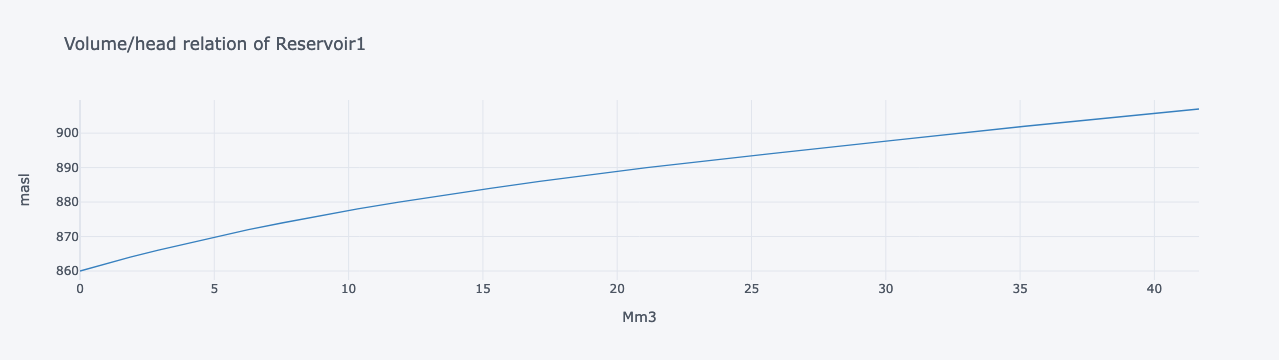

In [15]:
# Plotting the volume/head relation of Reservoir1
rsv1.vol_head.get().iplot(title="Volume/head relation of Reservoir1", xaxis_title="Mm3", yaxis_title="masl", color="blue")

Or they can be plotted in any style and design imaginable using your favorite plotting tools and packages.

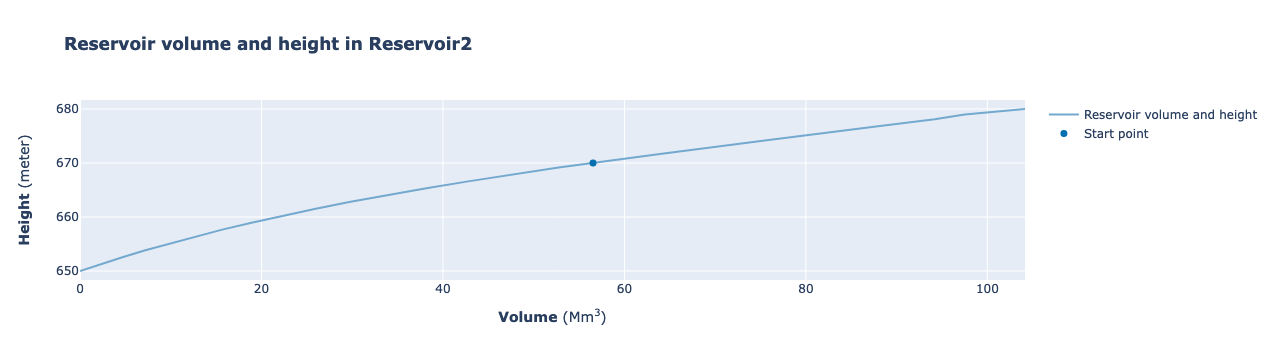

In [16]:
# Plotting the volume/head relation of Reservoir2, including the initial starting point

from scipy.interpolate import interp1d

vol_height=shop.model.reservoir.Reservoir2.vol_head.get()
start_height=shop.model.reservoir.Reservoir2.start_head.get()

interplation_function = interp1d(vol_height.values, vol_height.index)
start_volume=float(interplation_function(start_height))

fig = go.Figure()
colorscale = px.colors.sequential.PuBu_r
fig.add_trace(go.Scatter(x=vol_height.index, y=vol_height.values, name="Reservoir volume and height", marker_color=colorscale[4]))
fig.add_trace(go.Scatter(x=[start_volume], y=[start_height], name="Start point",marker_color=colorscale[2], mode='markers', marker=dict(color='rgba(0,0,0, 0.0)', size=3, line=dict(color=colorscale[2], width=4))))
fig.update_layout(title="<b>Reservoir volume and height in Reservoir2 </b>", xaxis_title="<b>Volume</b> (Mm<sup>3</sup>)", yaxis_title="<b>Height</b> (meter)")

fig.show()

### Plants

The next objects to add to our model are the plant objects. We instance them the same way as we instanced the reservoir objects.

In [17]:
# Add a plant objects to the model and instancing them
plant1 = shop.model.plant.add_object('Plant1')
plant2 = shop.model.plant.add_object('Plant2')
# Alternatively, only the right hand side can be executed, however it is often nice to refer to instances later on

Next we verify that our objects are correctly added to the shop instance.

In [18]:
shop.model.plant.get_object_names()

['Plant1', 'Plant2']

The plant objects need attributes as well.

In [19]:
# Setting the outlet line / tailrace height in masl
plant1.outlet_line.set(672)
plant2.outlet_line.set(586)

# Setting the main loss in the plant
plant1.main_loss.set([0])
plant2.main_loss.set([0])

# Setting the penstock loss in the plant. The number of penstocks are populated equal to the number of losses defined.
plant1.penstock_loss.set([0.001])
plant2.penstock_loss.set([0.0001,0.0002])

### Generators

A plant needs at least one generator. We add two generators to plant 1, and four generators to plant 2

In [20]:
# Add a generator object to the model
p1g1 = shop.model.generator.add_object('Plant1_Generator1')
p1g2 = shop.model.generator.add_object('Plant1_Generator2')

p2g1 = shop.model.generator.add_object('Plant2_Generator1')
p2g2 = shop.model.generator.add_object('Plant2_Generator2')
p2g3 = shop.model.generator.add_object('Plant2_Generator3')
p2g4 = shop.model.generator.add_object('Plant2_Generator4')

The connection between the generator and its plant must be set before defining the generator's parameters, whereas other connections in the model can be set after its objects and parameters have been set.

In [21]:
# Connecting the generator to the correct plant
p1g1.connect_to(plant1)
p1g2.connect_to(plant1)

p2g1.connect_to(plant2)
p2g2.connect_to(plant2)
p2g3.connect_to(plant2)
p2g4.connect_to(plant2)

We control the generator objects in the model after adding and connecting them.

In [22]:
shop.model.generator.get_object_names()

['Plant1_Generator1',
 'Plant1_Generator2',
 'Plant2_Generator1',
 'Plant2_Generator2',
 'Plant2_Generator3',
 'Plant2_Generator4']

Then we move on to the generator attributes. Certain generators are identical, so in order to preserve consistency, we make use of the .get()-function, so that if we change parameters on one of the duplicate generators, all of them will receive the change(s).

In [23]:
# Setting the number of penstocks
p1g1.penstock.set(1)
p1g2.penstock.set(p1g1.penstock.get())

p2g1.penstock.set(1)
p2g2.penstock.set(2)
p2g3.penstock.set(p2g2.penstock.get())
p2g4.penstock.set(p2g2.penstock.get())

# Setting the minimum production in MW
p1g1.p_min.set(60)
p1g2.p_min.set(p1g1.p_min.get())

p2g1.p_min.set(100)
p2g2.p_min.set(30)
p2g3.p_min.set(p2g2.p_min.get())
p2g4.p_min.set(p2g2.p_min.get())

# Setting the maximum production in MW
p1g1.p_max.set(120)
p1g2.p_max.set(p1g1.p_max.get())

p2g1.p_max.set(180)
p2g2.p_max.set(55)
p2g3.p_max.set(p2g2.p_max.get())
p2g4.p_max.set(p2g2.p_max.get())

# Setting the nominal production in MW
p1g1.p_nom.set(120)
p1g2.p_nom.set(p1g1.p_nom.get())

p2g1.p_nom.set(180)
p2g2.p_nom.set(55)
p2g3.p_nom.set(p2g2.p_nom.get())
p2g4.p_nom.set(p2g2.p_nom.get())

# Setting the start cost in a monetary unit (i.e. $ or NOK, the model only compares costs to each other, so you just need to be sure all costs are in the same unit)
p1g1.startcost.set(500)
p1g2.startcost.set(p1g1.startcost.get())

p2g1.startcost.set(600)
p2g2.startcost.set(200)
p2g3.startcost.set(p2g2.startcost.get())
p2g4.startcost.set(p2g2.startcost.get())

# Setting generator efficiency curves, which is the releation between the efficiency factor (%) and production (MW)
p1g1.gen_eff_curve.set(pd.Series([100, 100], index=[60, 120]))
p1g2.gen_eff_curve.set(p1g1.gen_eff_curve.get())

p2g1.gen_eff_curve.set(pd.Series([100, 100], index=[100, 180]))
p2g2.gen_eff_curve.set(pd.Series([100, 100], index=[30, 60]))
p2g3.gen_eff_curve.set(p2g2.gen_eff_curve.get())
p2g4.gen_eff_curve.set(p2g2.gen_eff_curve.get())

# Setting  turbine efficiency curves, which is the relation between the efficiency factor (%) and release (m3/s) for different head levels (masl)
p1g1.turb_eff_curves.set([pd.Series([85.8733, 87.0319, 88.0879, 89.0544, 89.9446, 90.7717, 91.5488, 92.2643, 92.8213, 93.1090, 93.2170, 93.0390, 92.6570, 92.1746],
                                    index=[28.12, 30.45, 32.78, 35.11, 37.45, 39.78, 42.11, 44.44, 46.77, 49.10, 51.43, 53.76, 56.10, 58.83],
                                    name=170),
                          pd.Series([86.7321, 87.9022, 88.9688, 89.9450, 90.8441, 91.6794, 92.4643, 93.1870, 93.7495, 94.0401, 94.1492, 93.9694, 93.5836, 93.0964],
                                    index=[28.12, 30.45, 32.78, 35.11, 37.45, 39.78, 42.11, 44.44, 46.77, 49.10, 51.43, 53.76, 56.10, 58.83],
                                    name=200),
                          pd.Series([87.5908, 88.7725, 89.8497, 90.8355, 91.7435, 92.5871, 93.3798, 94.1096, 94.6777, 94.9712, 95.0813, 94.8998, 94.5101, 94.0181],
                                    index=[28.12, 30.45, 32.78, 35.11, 37.45, 39.78, 42.11, 44.44, 46.77, 49.10, 51.43, 53.76, 56.10, 58.83],
                                    name=230)])
p1g2.turb_eff_curves.set(p1g1.turb_eff_curves.get())

p2g1.turb_eff_curves.set([pd.Series([92.7201, 93.2583, 93.7305, 94.1368, 94.4785, 94.7525, 94.9606, 95.1028, 95.1790, 95.1892, 95.1335, 95.0118, 94.8232, 94.5191],
                                    index=[126.54, 137.03, 147.51, 158.00, 168.53, 179.01, 189.50, 199.98, 210.47, 220.95, 231.44, 241.92, 252.45, 264.74],
                                    name=60)])

p2g2.turb_eff_curves.set([pd.Series([83.8700, 85.1937, 86.3825, 87.4362, 88.3587, 89.1419, 89.7901, 90.3033, 90.6815, 90.9248, 91.0331, 91.0063, 90.8436, 90.4817],
                                    index=[40.82, 44.20, 47.58, 50.97, 54.36, 57.75, 61.13, 64.51, 67.89, 71.27, 74.66, 78.04, 81.44, 85.40],
                                    name=60)])
p2g3.turb_eff_curves.set(p2g2.turb_eff_curves.get())
p2g4.turb_eff_curves.set(p2g2.turb_eff_curves.get())

Now we can plot some of the generator data, to ensure that we have the correct data.

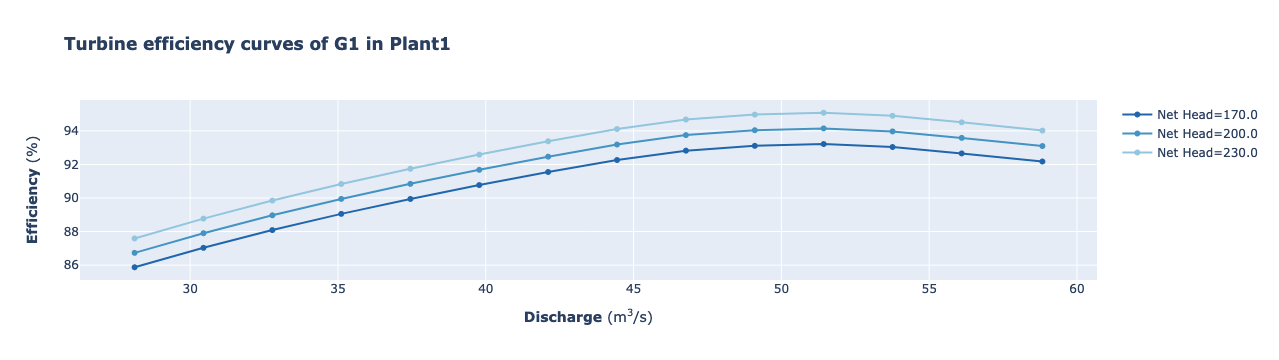

In [24]:
# Plotting the turbine efficiency curves of G1 (G2 is the same as G1) in Plant1 
turb_eff_curves=shop.model.generator.Plant1_Generator1.turb_eff_curves.get()

fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
color = 0
for curve in turb_eff_curves:
    color+=1
    curve_name="Net Head="+str(curve.name)
    fig.add_trace(go.Scatter(x=curve.index, y=curve.values, marker_color = colorscale[color], name=curve_name, mode="lines+markers", line=dict(width=2)))

fig.update_layout(title="<b>Turbine efficiency curves of G1 in Plant1</b>", xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Efficiency</b> (%)")

fig.show()

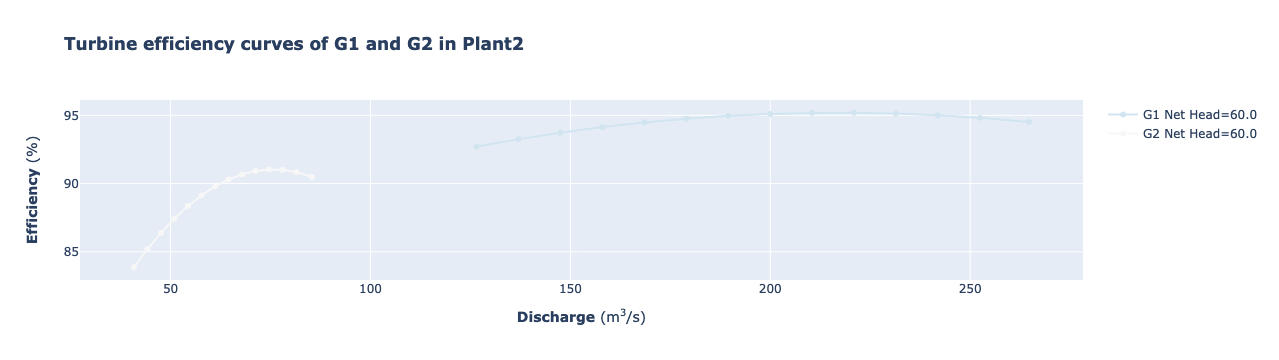

In [25]:
# Plot the turbine efficiency curves of G1 and G2 (G3, G4 are the same as G2) in Plant2 
turb_eff_curves_G1=shop.model.generator.Plant2_Generator1.turb_eff_curves.get()
turb_eff_curves_G2=shop.model.generator.Plant2_Generator2.turb_eff_curves.get()

fig = go.Figure()

for curve in turb_eff_curves_G1:
    color+=1
    curve_name="G1 Net Head="+str(curve.name)
    fig.add_trace(go.Scatter(x=curve.index, y=curve.values, marker_color = colorscale[color], name=curve_name, mode="lines+markers", line=dict(width=2)))

for curve in turb_eff_curves_G2:
    color+=1
    curve_name="G2 Net Head="+str(curve.name)
    fig.add_trace(go.Scatter(x=curve.index, y=curve.values, marker_color = colorscale[color], name=curve_name, mode="lines+markers", line=dict(width=2)))
    
fig.update_layout(title="<b>Turbine efficiency curves of G1 and G2 in Plant2</b>", xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Efficiency</b> (%)")

fig.show()

### Gates

Water routes such as spillways, bypasses and gates between objects, can be defined and applied with certain attributes as well.

In [26]:
# Adding a spillway between Reservoir 1 and Reservoir 2
s_rsv1_rsv2 = shop.model.gate.add_object('s_Reservoir1_Reservoir2')

# Adding a bypass between Reservoir 1 and Reservoir 2
b_rsv1_rsv2 = shop.model.gate.add_object('b_Reservoir1_Reservoir2')

# Adding a spillway between Reservoir 1 and Reservoir 2
s_rsv2_ocean = shop.model.gate.add_object('s_Reservoir2_Ocean')

# Adding a bypass between Reservoir 1 and Reservoir 2
b_rsv2_ocean = shop.model.gate.add_object('b_Reservoir2_Ocean')

And we do a quick control of the content on gate objects afterwards.

In [27]:
shop.model.gate.get_object_names()

['s_Reservoir1_Reservoir2',
 'b_Reservoir1_Reservoir2',
 's_Reservoir2_Ocean',
 'b_Reservoir2_Ocean']

## Connecting the topology objects

After adding the objects and defining parameters to them, we need to connect them together in order for the model to know which parts that can interact with each other. This means for instance that we need to connect a certain reservoir to a certain plant. In this example, *Reservoir1* should connect to *Plant1*, Plant1 should then further be connected to *Reservoir2*, whereas Reservoir2 again connects to *Plant2*. Additionally, we need to correcrtly connect the gates, spillways and bypasses. We always connect objects from the top to the bottom, starting with the uppermost object relative to elevation. Note that it is necessary to specify the keyword argument "connection_type" when connecting a bypass or spill gate to the upper reservoir, but it is not needed when the bypass or spill gate is connected to the downstream reservoir. 

In [28]:
# Connecting Reservoir 1 to Plant1
rsv1.connect_to(plant1)

# Connecting Reservoir 1 to the bypass between Reservoir1 and Reservoir2
rsv1.connect_to(b_rsv1_rsv2,connection_type="bypass")

# Connecting Reservoir 1 to the spillway between Reservoir1 and Reservoir2
rsv1.connect_to(s_rsv1_rsv2,connection_type="spill")

# Connecting Plant1 to Reservoir2
plant1.connect_to(rsv2)

# Connecting the bypass between Reservoir1 and Reservoir2 to Reservoir2
b_rsv1_rsv2.connect_to(rsv2)

# Connecting the spillway between Reservoir1 and Reservoir2 to Reservoir2
s_rsv1_rsv2.connect_to(rsv2)

# Connecting Reservoir2 to Plant 2
rsv2.connect_to(plant2)

# Connecting Reservoir2 to the bypass between Reservoir2 and Ocean
rsv2.connect_to(b_rsv2_ocean,connection_type="bypass")

# Connecting Reservoir2 to the spillway between Reservoir2 and Ocean
rsv2.connect_to(s_rsv2_ocean,connection_type="spill")

We can then verify if the topology is correctly set up, by graphing out the topology tree.

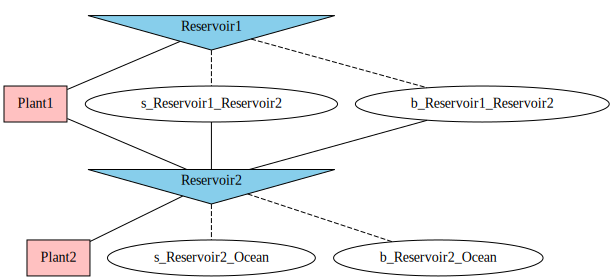

In [29]:
# Print out the topology
dot = shop.model.build_connection_tree()
display(dot)

## Adding a market and a load

Lastly, we need to add a market and/or a load for the model to optimize against, with certain parameters. This gives SHOP the solution space it needs to make its decisions on where and when to produce or not, while maximizing profit and fulfilling load requirements.

In [30]:
# Adding a market named "Day_ahead"
shop.model.market.add_object('Day_ahead')

# Instancing the market Day_ahead to 'da'
da = shop.model.market.Day_ahead

# Setting a sale price to the market, which is the income value (in monetary units) per produced MW
da.sale_price.set(pd.DataFrame([32.992,31.122,29.312,28.072,30.012,33.362,42.682,74.822,77.732,62.332,55.892,46.962,42.582,40.942,39.212,39.142,41.672,46.922,37.102,32.992,31.272,29.752,28.782,28.082,27.242,26.622,25.732,25.392,25.992,27.402,28.942,32.182,33.082,32.342,30.912,30.162,30.062,29.562,29.462,29.512,29.672,30.072,29.552,28.862,28.412,28.072,27.162,25.502,26.192,25.222,24.052,23.892,23.682,26.092,28.202,30.902,31.572,31.462,31.172,30.912,30.572,30.602,30.632,31.062,32.082,36.262,34.472,32.182,31.492,30.732,29.712,28.982], 
                               index=[starttime + pd.Timedelta(hours=i) for i in range(0,72)]))

# Setting a buy price to the market, which is the cost to buy production in the market (in monetary units) in stead of producing it yourself per MW. This is normally used when you have a load to cover or if you have pumps
da.buy_price.set(da.sale_price.get()+0.002)

# Setting the amount of volume able to buy in the market in MW
da.max_buy.set(pd.Series([9999], [starttime]))

# Setting the amount of volume able to sell (produce) in the market in MW
da.max_sale.set(pd.Series([9999], [starttime]))

# Setting the load that needs to be fullfilled, either by power production or by buying from the market, depending on the above parameters
da.load.set(pd.Series([0], [starttime]))

Now we can compare the market price to the (constant) evalutation value of the water in the reservoirs. Endpoint descriptions are usually more complex, depending on reservoir levels and/or other reservoirs. 

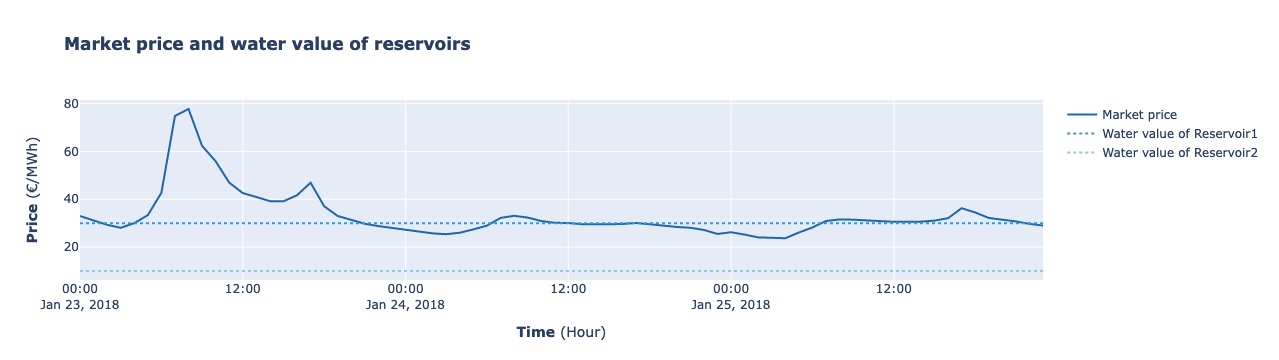

In [31]:
# Plot market price and water value of reservoirs
spot_price=shop.model.market.Day_ahead.sale_price.get()
end_water_value=shop.model.reservoir.Reservoir1.energy_value_input.get()
water_value=pd.Series(dtype=object,index=spot_price.index)
water_value=water_value.fillna(end_water_value)


fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
color = 1
fig.add_trace(go.Scatter(x=spot_price.index, marker_color = colorscale[color], y=spot_price.values, name="Market price"))

for rsv in shop.model.reservoir:
    color+=1
    end_water_value=rsv.energy_value_input.get()
    water_value=pd.Series(dtype=object,index=spot_price.index)
    water_value=water_value.fillna(end_water_value)
    curve_name="Water value of "+rsv.get_name()
    fig.add_trace(go.Scatter(x=water_value.index, y=water_value.values, marker_color = colorscale[color], name=curve_name, line=dict(dash="dot")))
    
fig.update_layout(title="<b>Market price and water value of reservoirs</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Price</b> (€/MWh)")

fig.show()

## Running SHOP

Once the model is fully defined, we can prepare for a call to the optimizer. It is possible to define certain criteria depending on the solver used, if not, default values will be effective. 

In order to find an optimal solution, it is normal to run SHOP with multiple iterations, both full and incremental.

In [32]:
# Setting a full flag, telling SHOP the upcomming iterations should be full
shop.set_code(['full'], [])

# Starting SHOP and running five (full) iterations
shop.start_sim([], ['5'])

# Setting an incremental flag, telling SHOP the next iterations should be incremental
shop.set_code(['incremental'], [])

# Running three more (incremental) iterations
shop.start_sim([], ['3'])

True

## Results

After the optimization has completed, we can review the result from SHOP by plotting the graphs we want. 

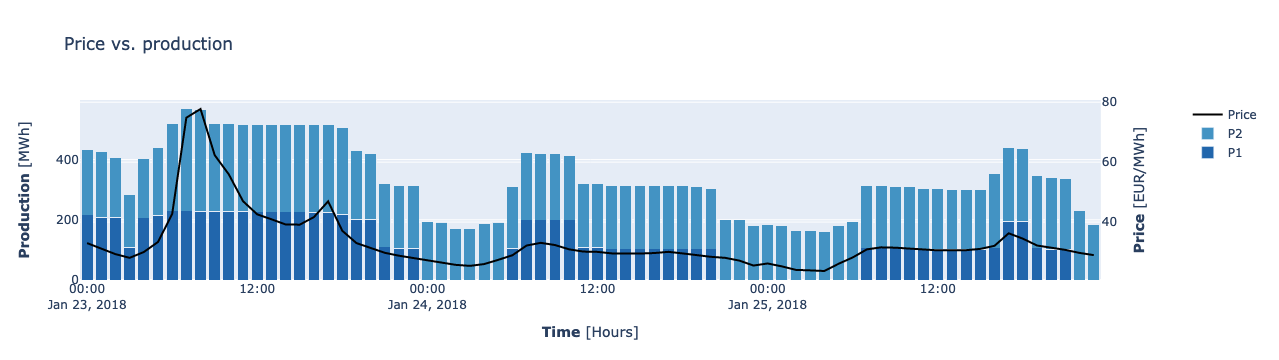

In [33]:
# Plotting price vs. production

# Defining a plot instance
fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
# Preparing for secondary y axis by calling make_subplots function
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Adding plant production as traces of bar type
fig.add_trace(go.Bar(x=shop.model.plant.Plant1.production.get().index, y=shop.model.plant.Plant1.production.get().values, name="P1", marker_color=colorscale[1]))
fig.add_trace(go.Bar(x=shop.model.plant.Plant2.production.get().index, y=shop.model.plant.Plant2.production.get().values, name="P2", marker_color=colorscale[2]))
# Stacking bars
fig.update_layout(barmode='stack')
# Adding price as trace of scatter type
fig.add_trace(go.Scatter(x=shop.model.market.Day_ahead.sale_price.get().index, y=shop.model.market.Day_ahead.sale_price.get().values, name="Price", line_color='black'),secondary_y=True)
# Updating titles
fig.update_layout(title_text="Price vs. production")
fig.update_yaxes(title_text="<b>Production</b> [MWh]", secondary_y=False)
fig.update_yaxes(title_text="<b>Price</b> [EUR/MWh]", secondary_y=True)
fig.update_xaxes(title_text="<b>Time</b> [Hours]")
# Show plot
fig.show()

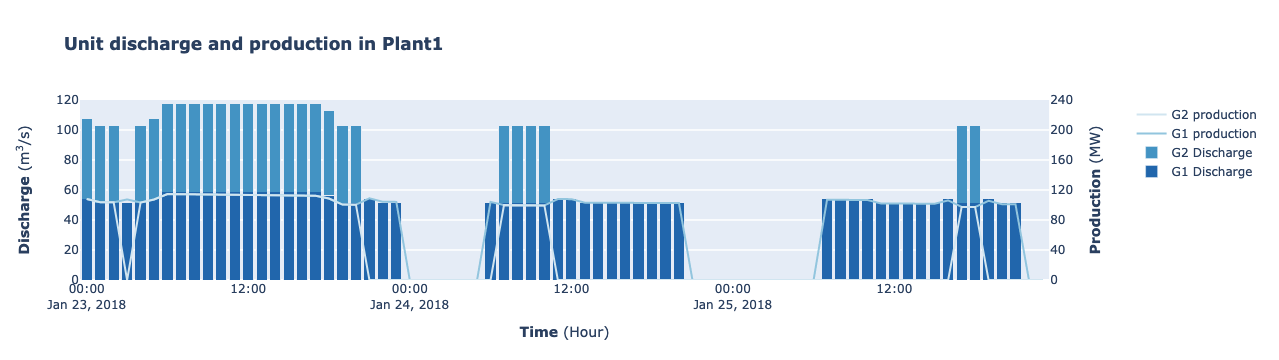

In [34]:
# Plotting discharge and production results from Plant 1

# Retrieving discharge results on generators
G1_discharge=shop.model.generator.Plant1_Generator1.discharge.get()
G2_discharge=shop.model.generator.Plant1_Generator2.discharge.get()

# Retrieving production results on generators
G1_production=shop.model.generator.Plant1_Generator1.production.get()
G2_production=shop.model.generator.Plant1_Generator2.production.get()

# Preparing for secondary y axis by calling make_subplots function
coloraxis = px.colors.sequential.RdBu_r
#coloraxis=["rgb(0, 200, 30)","rgb(0, 200, 60)","rgb(0, 200, 90)","rgb(0, 200, 120)","rgb(0, 200, 150)","rgb(0, 200, 180)","rgb(0, 200, 210)","rgb(0, 200, 255)"]
#print(coloraxis)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=G1_discharge.index, y=G1_discharge.values, name="G1 Discharge", marker_color=coloraxis[1]), secondary_y=False)
fig.add_trace(go.Bar(x=G2_discharge.index, y=G2_discharge.values, name="G2 Discharge", marker_color=coloraxis[2]), secondary_y=False)
fig.add_trace(go.Scatter(x=G1_production.index, y=G1_production.values, name="G1 production", marker_color=coloraxis[3]), secondary_y=True)
fig.add_trace(go.Scatter(x=G2_production.index, y=G2_production.values, name="G2 production", marker_color=coloraxis[4]), secondary_y=True)
fig.update_layout(title_text="<b>Unit discharge and production in Plant1</b>", barmode="stack")
fig.update_xaxes(title_text="<b>Time</b> (Hour)")
fig.update_yaxes(title_text="<b>Discharge</b> (m<sup>3</sup>/s)", secondary_y=False, range=[0, 120], tick0=20, dtick=20)
fig.update_yaxes(title_text="<b>Production</b> (MW)", secondary_y=True, range=[0, 240], tick0=40, dtick=40)

fig.show()

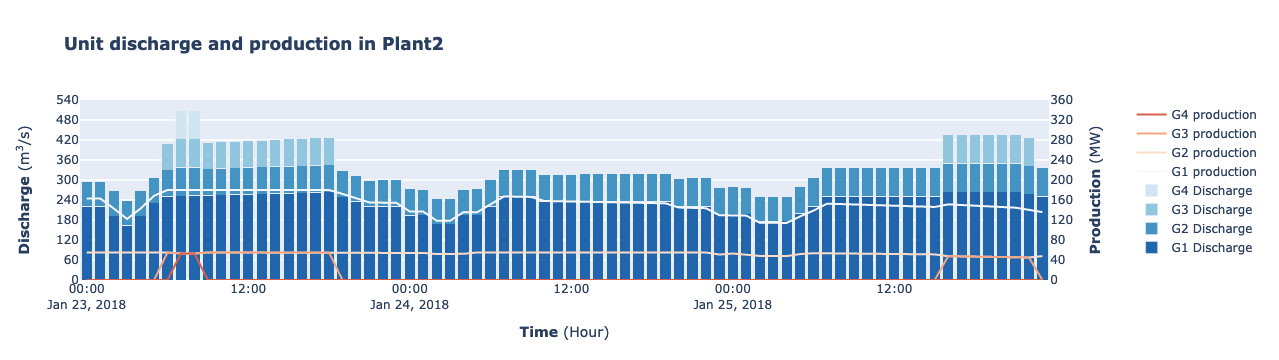

In [35]:
# Plotting discharge and production results from Plant 2

# Retrieving discharge results on generators
G1_discharge=shop.model.generator.Plant2_Generator1.discharge.get()
G2_discharge=shop.model.generator.Plant2_Generator2.discharge.get()
G3_discharge=shop.model.generator.Plant2_Generator3.discharge.get()
G4_discharge=shop.model.generator.Plant2_Generator4.discharge.get()

# Retrieving discharge results on generators
G1_production=shop.model.generator.Plant2_Generator1.production.get()
G2_production=shop.model.generator.Plant2_Generator2.production.get()
G3_production=shop.model.generator.Plant2_Generator3.production.get()
G4_production=shop.model.generator.Plant2_Generator4.production.get()

from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
colorscale = px.colors.sequential.RdBu_r
fig.add_trace(go.Bar(x=G1_discharge.index, y=G1_discharge.values, name="G1 Discharge", marker_color=colorscale[1]), secondary_y=False)
fig.add_trace(go.Bar(x=G2_discharge.index, y=G2_discharge.values, name="G2 Discharge", marker_color=colorscale[2]), secondary_y=False)
fig.add_trace(go.Bar(x=G3_discharge.index, y=G3_discharge.values, name="G3 Discharge", marker_color=colorscale[3]), secondary_y=False)
fig.add_trace(go.Bar(x=G4_discharge.index, y=G4_discharge.values, name="G4 Discharge", marker_color=colorscale[4]), secondary_y=False)
fig.add_trace(go.Scatter(x=G1_production.index, y=G1_production.values, name="G1 production", marker_color=colorscale[5]), secondary_y=True)
fig.add_trace(go.Scatter(x=G2_production.index, y=G2_production.values, name="G2 production", marker_color=colorscale[6]), secondary_y=True)
fig.add_trace(go.Scatter(x=G3_production.index, y=G3_production.values, name="G3 production", marker_color=colorscale[7]), secondary_y=True)
fig.add_trace(go.Scatter(x=G4_production.index, y=G4_production.values, name="G4 production", marker_color=colorscale[8]), secondary_y=True)
fig.update_layout(title_text="<b>Unit discharge and production in Plant2</b>", barmode="stack")
fig.update_xaxes(title_text="<b>Time</b> (Hour)")
fig.update_yaxes(title_text="<b>Discharge</b> (m<sup>3</sup>/s)", secondary_y=False, range=[0, 540], tick0=60, dtick=60)
fig.update_yaxes(title_text="<b>Production</b> (MW)", secondary_y=True, range=[0, 360], tick0=40, dtick=40)
fig.show()

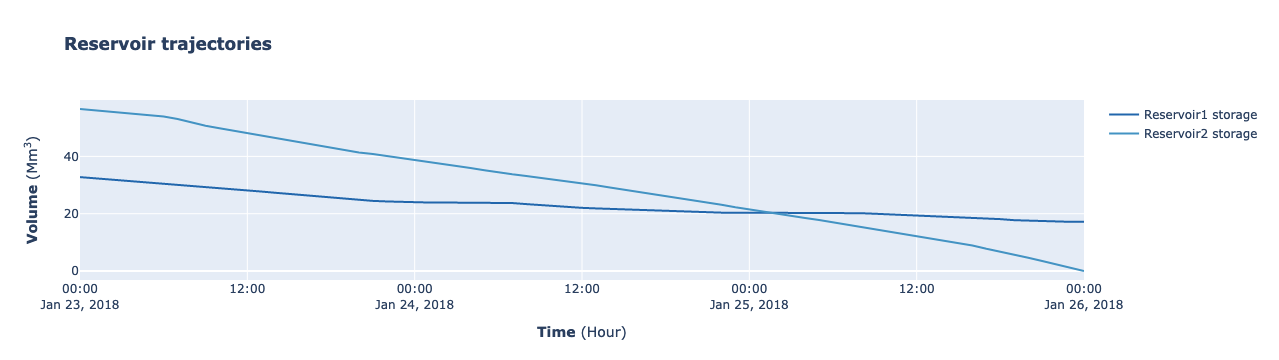

In [36]:
# Plotting reservoir trajectories
water_storage_rsv1=shop.model.reservoir.Reservoir1.storage.get()
water_storage_rsv2=shop.model.reservoir.Reservoir2.storage.get()
fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
fig.add_trace(go.Scatter(x=water_storage_rsv1.index, y=water_storage_rsv1.values, name="Reservoir1 storage", marker_color=colorscale[1]))
fig.add_trace(go.Scatter(x=water_storage_rsv2.index, y=water_storage_rsv2.values, name="Reservoir2 storage", marker_color=colorscale[2]))
fig.update_layout(title="<b>Reservoir trajectories </b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Volume</b> (Mm<sup>3</sup>)")
fig.show()

Lastly, we can inspect individual values describing our model run.

In [37]:
print("Income from fixed load:",shop.model.objective.scen_1.load_value.get())
print("Sum of selling vs. buying in the market:", shop.model.objective.scen_1.market_sale_buy.get())
print("End reservoir value:", shop.model.objective.scen_1.rsv_end_value.get())
print("Sum of startup costs:", shop.model.objective.scen_1.startup_costs.get())
print("Sum of load penalties:", shop.model.objective.scen_1.load_penalty.get())
print("Total objective value:", shop.model.objective.scen_1.total.get())
print("Grand total objective value (excluding major penalties):", shop.model.objective.scen_1.grand_total.get())

Income from fixed load: -0.0
Sum of selling vs. buying in the market: -874097.1583116516
End reservoir value: -335498.5310546689
Sum of startup costs: 3100.0
Sum of load penalties: 0.0
Total objective value: -1206495.6893663204
Grand total objective value (excluding major penalties): -1206495.6893663204
